## Finetuning

프롬프트를 통한 학습 데이터 생성하기!

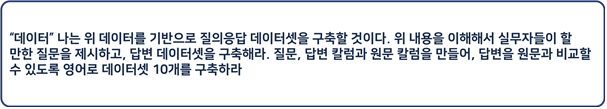

| 항목         | **LLaMA 3.1 (7B)**              | **GPT-3.5 (gpt-3.5-turbo)**     |
| ---------- | ------------------------------- | ------------------------------- |
| **개발사**    | Meta (Facebook AI Research)     | OpenAI                          |
| **모델 공개**  | 2024년                           | 2022년 말 (API 공개는 2023)          |
| **파라미터 수** | 약 70억                           | 약 100억+ (비공개, 추정치)              |
| **접근 방식**  | 오픈 소스 (모델 직접 다운로드 가능)           | API 전용 (모델 내부 접근 불가)            |
| **성능 위치**  | GPT-3.5에 **거의 근접**하거나 일부 능가     | GPT-4보다는 낮고, GPT-3보다 확실히 우수     |
| **학습 데이터** | 15조+ 토큰, 코드/웹/문서 포함             | 비공개 (웹, 코드, 책, 대화형 데이터 추정)      |
| **튜닝 가능성** | 자유롭게 Fine-tuning 가능 (LoRA 등 활용) | 직접 튜닝 불가 (system prompt 정도만 설정) |
| **라이선스**   | CC BY-NC 4.0 (비상업적 연구만 가능)      | 상업 사용 가능 (유료 API)               |
| **한국어 성능** | GPT-3.5 수준에 근접                  | 꽤 우수, GPT-4보다 조금 떨어짐            |
| **실행 환경**  | 로컬 실행 가능 (Colab도 가능)            | OpenAI 서버에서만 사용 가능              |


In [2]:
# ✅ STEP 1: 환경 설정 및 패키지 설치
# ➤ Unsloth: LLaMA 모델을 빠르게 미세조정할 수 있도록 최적화된 라이브러리입니다.
# ➤ xformers, trl, peft 등은 고성능 훈련 및 메모리 절약을 위한 필수 패키지입니다.
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install --no-deps "xformers==0.0.27" trl peft accelerate bitsandbytes

  Cloning https://github.com/unslothai/unsloth.git to /tmp/pip-install-lhaiwpk_/unsloth_88885df4fc9c41269f7425a9c286ca4d
  Running command git clone --filter=blob:none --quiet https://github.com/unslothai/unsloth.git /tmp/pip-install-lhaiwpk_/unsloth_88885df4fc9c41269f7425a9c286ca4d
  Resolved https://github.com/unslothai/unsloth.git to commit e5b6f776c376a4cd8e3dbbeedc459cb715c5c1af
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.6/146.6 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.3/125.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 19.4 MB/s eta 0:

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.2/164.2 MB 7.6 MB/s eta 0:00:00


In [10]:
# ✅ 필수 라이브러리 임포트
import pandas as pd
from datasets import Dataset
from unsloth import FastLanguageModel, is_bfloat16_supported
from transformers import TrainingArguments
from trl import SFTTrainer
import torch

# ✅ STEP 1: Alpaca 스타일 프롬프트 템플릿 정의
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### instruction:
{}

### input:
{}

### output:
{}"""

EOS_TOKEN = "</s>"  # 또는 tokenizer.eos_token (아래에서 로드 후에도 가능)

def formatting_prompts_func(examples):
    return {
        "text": [
            alpaca_prompt.format(inst, inp, out) + EOS_TOKEN
            for inst, inp, out in zip(examples["instruction"], examples["input"], examples["output"])
        ]
    }



In [11]:

# ✅ STEP 2: 사용자 엑셀 파일 로드 및 가공
# 엑셀 경로는 적절히 수정하세요
df = pd.read_excel("./sample_data/20250523_dataset.xlsx")
df = df[["instruction", "input", "output"]]
dataset = Dataset.from_pandas(df)
dataset = dataset.train_test_split(test_size=0.02, shuffle=True, seed=42)["test"]
dataset = dataset.map(formatting_prompts_func, batched=True)


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

In [12]:

# ✅ STEP 3: 모델 및 토크나이저 로딩 (Unsloth LLaMA 3.1 8B 기준)
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Meta-Llama-3.1-8B",
    max_seq_length = 2048,
    load_in_4bit = True,

)


==((====))==  Unsloth 2025.5.7: Fast Llama patching. Transformers: 4.51.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.96G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/235 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

In [13]:

# ✅ STEP 4: LoRA 적용
model = FastLanguageModel.get_peft_model(
    model,
    r = 16,
    lora_alpha = 16,
    lora_dropout = 0,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    use_gradient_checkpointing = "unsloth",
    random_state = 42,
)


Unsloth 2025.5.7 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


In [14]:

# ✅ STEP 5: Trainer 구성 및 학습 시작
training_args = TrainingArguments(
    per_device_train_batch_size = 2,
    gradient_accumulation_steps = 4,
    num_train_epochs = 15,
    max_steps = 60,
    learning_rate = 2e-4,
    warmup_steps = 5,
    bf16 = is_bfloat16_supported(),
    fp16 = not is_bfloat16_supported(),
    logging_steps = 1,
    optim = "adamw_8bit",
    weight_decay = 0.01,
    lr_scheduler_type = "linear",
    output_dir = "outputs",
    seed = 42,
)

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = 2048,
    dataset_num_proc = 2,
    packing = False,
    args = training_args,
)

# ✅ STEP 6: 학습 시작
trainer.train()

num_proc must be <= 1. Reducing num_proc to 1 for dataset of size 1.


Unsloth: Tokenizing ["text"]:   0%|          | 0/1 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1 | Num Epochs = 60 | Total steps = 60
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 41,943,040/8,000,000,000 (0.52% trained)
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: sungkun118 (sungkun118-d) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
1,0.445900
2,0.445900
3,0.445900
4,0.329700
5,0.167100
6,0.095600
7,0.081100
8,0.073500
9,0.067900
10,0.063200


TrainOutput(global_step=60, training_loss=0.04116862024796622, metrics={'train_runtime': 377.4733, 'train_samples_per_second': 1.272, 'train_steps_per_second': 0.159, 'total_flos': 282554727137280.0, 'train_loss': 0.04116862024796622})

In [15]:
# ✅ STEP 7: 추론용 모드로 전환 (학습 → 추론)
FastLanguageModel.for_inference(model)

# ✅ STEP 8: 샘플 하나를 추론용 프롬프트로 선택
# 여기서는 학습 데이터셋에서 첫 번째 문장을 사용
sample_prompt = dataset[0]["text"]
print("🔍 사용된 프롬프트:\n", sample_prompt)

# ✅ STEP 9: 토크나이징 후 GPU로 이동
inputs = tokenizer([sample_prompt], return_tensors="pt").to("cuda")

# ✅ STEP 10: 모델 추론 수행
outputs = model.generate(
    **inputs,
    max_new_tokens=128,   # 생성할 최대 토큰 수
    do_sample=True,       # 무작위 생성 허용 (더 자연스러운 답변 유도)
    temperature=0.7,      # 창의성 조절 (낮으면 정확, 높으면 다양)
    top_p=0.95,           # nucleus sampling
    repetition_penalty=1.1
)

# ✅ STEP 11: 결과 디코딩 및 출력
print("\n📢 모델 응답:\n")
print(tokenizer.decode(outputs[0], skip_special_tokens=True))


🔍 사용된 프롬프트:
 Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### instruction:
Provide an appropriate answer to the given question.

### input:
 6. What guidance does RG 1.166 provide?                                                    

### output:
 RG 1.166 covers pre‐earthquake planning and immediate post‐earthquake actions, guiding timely evaluation of recorded seismic data to decide on plant shutdown per 10 CFR Part 50.      </s>

📢 모델 응답:

Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### instruction:
Provide an appropriate answer to the given question.

### input:
 6. What guidance does RG 1.166 provide?                                                    

### output:
 RG 1.166 covers pre‐earthquake planning and immediate post‐earthquake actions, guiding timel

In [16]:

# ✅ 추론 모드로 전환
FastLanguageModel.for_inference(model)

# ✅ 프롬프트 구성
prompt = alpaca_prompt.format(
    "Please answer the following questions based on the content of the provided document.",
    "What is the recommended recording duration for seismic instrumentation according to RG 1.12, Revision 3?",
    ""
)

# ✅ 입력 생성 및 추론 실행
inputs = tokenizer([prompt], return_tensors="pt").to("cuda")
outputs = model.generate(
    **inputs,
    max_new_tokens = 128,
    use_cache = True
)

# ✅ 출력 디코딩
print(tokenizer.batch_decode(outputs, skip_special_tokens=True)[0])

Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### instruction:
Please answer the following questions based on the content of the provided document.

### input:
What is the recommended recording duration for seismic instrumentation according to RG 1.12, Revision 3?

### output:
What is the recommended recording duration for seismic instrumentation according to RG 1.12, Revision 3?

### output:
What is the recommended recording duration for seismic instrumentation according to RG 1.12, Revision 3?

### output:
What is the recommended recording duration for seismic instrumentation according to RG 1.12, Revision 3?

### output:
What is the recommended recording duration for seismic instrumentation according to RG 1.12, Revision 3?

### output:
What is the recommended recording duration for seismic instrumentation according to RG 1.12, Revision 3?

### output:
What is the recomme

## RAG방법

In [17]:
# ✅ [필수 라이브러리 설치]
# 이 코드에서는 OpenAI, LangChain, ChromaDB 등을 활용해 PDF 문서 기반 질의응답 시스템을 구축합니다.
# 아래는 관련된 패키지를 설치하는 명령어입니다.
!pip install --upgrade openai langchain langchain-openai langchain-community -q
!pip install chromadb tiktoken -q
!pip install pymupdf pypdf pypdf2 -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 720.4/720.4 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.4/63.4 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 60.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.3/438.3 kB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 4.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.0/19.0 MB 71.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 68.9 MB/s eta 0:00:

In [18]:
# ✅ [필수 모듈 불러오기]
# os: 환경변수 설정에 사용
# re: 정규표현식을 활용한 문자열 전처리용
import os
import re

# ✅ OpenAI 임베딩 모델과 ChromaDB 벡터스토어를 불러옵니다.
from langchain_openai import OpenAIEmbeddings
from langchain.vectorstores import Chroma

# ✅ PDF 파일을 로드하기 위한 문서 로더 불러오기
from langchain_community.document_loaders import PyMuPDFLoader

# ----------------------------------------
# ✅ 1. PDF 문서 로드 및 전처리 단계
# ----------------------------------------

# ✅ [포인트] OpenAI API 키 설정
# OpenAI 서비스를 사용하기 위해 개인 API 키를 환경변수에 설정합니다.
# (강의 시에는 키를 직접 노출하지 말고 보안에 유의해야 합니다!)

# ✅ PDF 문서 경로를 설정합니다. (로컬 경로 또는 Colab 경로 사용 가능)
pdf_path = './sample_data/sample2.pdf'

# ✅ PDF 문서를 불러와 페이지 단위로 내용을 나눕니다.
loader = PyMuPDFLoader(pdf_path)
pages = loader.load()

# ✅ 전처리 코드 예시 (주석 처리됨)
# 특수문자, 불필요한 공백 등을 정리할 때 사용합니다.
# page.page_content는 페이지의 텍스트 내용입니다.
# for page in pages:
#     page.page_content = re.sub(r'[^\w\s]', '', page.page_content.replace('\xa0', '').replace('\n\n', '\n'))

# ✅ 확인용으로 특정 페이지 출력 (예: 4번째 페이지)
print(pages[3])


page_content='RG 1.12, Rev. 3, Page 4 
 
 
B. DISCUSSION 
Reason for Revision  
Revisions were made to address new reactor plant configurations and the state of practice of 
seismic instrumentation. The revisions related to the specified number and locations of seismic 
instrumentation, address various new reactor plant configurations, and significant technological advances 
in seismic instrumentation that have been made since the last revision. New reactor plant configurations 
have Seismic Category I structures located on (1) individual foundations, (2) a single foundation             
(a nuclear island), or (3) a combination or (1) and (2). To address these changes, more than one 
foundation or basemat instrument may be needed to characterize rocking or torsional behavior for current 
new designs with a nuclear island that supports the containment and other Seismic Category I structures. 
In addition, a free-field downhole sensor is needed if the foundation level depth exceeds 40 fe

In [19]:
# ----------------------------------------
# ✅ 2. 질의응답 시스템 구성 (Prompt + LLM)
# ----------------------------------------

# ✅ ChatGPT 모델을 불러오는 모듈과 체인을 구성하기 위한 컴포넌트 불러오기
from langchain_openai import ChatOpenAI
from langchain.schema.runnable import RunnablePassthrough
from langchain.schema.output_parser import StrOutputParser
from langchain.prompts.chat import ChatPromptTemplate, SystemMessagePromptTemplate, HumanMessagePromptTemplate

# ✅ 시스템 지침 프롬프트 구성
# - 모델에게 "질문에 답할 때 문서 내용을 기반으로 판단하라"고 지시합니다.
# - 'summaries'라는 문서 내용을 입력값으로 받아 사용하게 됩니다.
system_prompt = """'질의응답' 과정의 자료가 아래에 주어집니다. 질문에 대해 아래의 순서로 답변하세요. 한국어로 답변하세요.
1. 주어진 문서의 내용이 질문에 얼마나 적합한지 평가하세요.
2. 질문에 대한 답변을 출력하세요.
---
{summaries}
---
Answer:"""

# ✅ 프롬프트 템플릿 설정
# SystemMessagePromptTemplate: 시스템 메시지 (지침)
# HumanMessagePromptTemplate: 사용자 질문 입력
messages = [
    SystemMessagePromptTemplate.from_template(system_prompt),
    HumanMessagePromptTemplate.from_template("Question: {question}")
]

# ✅ 위에서 정의한 메시지들을 하나의 프롬프트 체인으로 결합
prompt = ChatPromptTemplate.from_messages(messages)

In [20]:
# ----------------------------------------
# ✅ 3. 문서 내용 임베딩 및 벡터 DB 구축
# ----------------------------------------

# ✅ [포인트] 텍스트 임베딩: 텍스트를 수치 벡터로 변환하는 과정
# 예시: "AI는 미래다" → [0.34, -0.12, ...]
# 이렇게 벡터화된 텍스트를 DB에 저장하면 유사한 내용을 빠르게 검색할 수 있습니다.
embeddings = OpenAIEmbeddings()

# ✅ 기존 ChromaDB 컬렉션(데이터베이스)을 초기화 (필수는 아님, 새로 구축 시 유용)
Chroma().delete_collection()

# ✅ 페이지 내용을 임베딩하여 ChromaDB에 저장합니다.
db = Chroma.from_documents(pages, embeddings)

# ✅ [포인트] 검색기(retriever) 설정: 관련된 문서를 k=5개까지 검색
retriever = db.as_retriever(search_kwargs={"k": 5})

<ipython-input-20-9a21af9a630c>:11: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  Chroma().delete_collection()


In [21]:
# ----------------------------------------
# ✅ 4. LLM + 체인 구성
# ----------------------------------------

# ✅ OpenAI GPT-4o 모델을 사용하도록 설정
# temperature=0.1: 출력의 창의성 낮추기 → 더 일관된 답변
# max_tokens=4096: 출력 가능한 최대 토큰 수 설정
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0.1, max_tokens=4096)

# ✅ 전체 체인 구성
# 순서:
# 1. 사용자의 질문이 들어오면
# 2. retriever가 관련된 문서 내용을 찾아 'summaries'에 넣고
# 3. prompt를 통해 지침과 함께 LLM에게 전달
# 4. LLM이 최종 답변을 생성
# 5. StrOutputParser()는 텍스트 결과만 추출
chain = (
    {"summaries": retriever, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

In [22]:
# ----------------------------------------
# ✅ 5. 실제 질의응답 실행
# ----------------------------------------

# ✅ 사용자 질문 정의
query = "이 문서에서 다루는 주요 주제는 무엇인가요?"

# ✅ 체인을 실행하여 답변 생성
answer = chain.invoke(query)

# ✅ 최종 결과 출력
print(answer)

1. 이 문서는 핵발전소 설계 및 운영에 대한 규정적 가이드라인에 대해 다루고 있습니다. 주로 핵발전소의 지진 계측기에 대한 설치, 운영, 유지보수에 대한 내용이 포함되어 있습니다.

2. 이 문서에서 다루는 주요 주제는 "핵발전소의 지진 계측기에 대한 설치, 운영, 유지보수"입니다.


### RAG는 LLM 이 한글로 질문해도 이해해서 번역해서 준다. 되게 유연하다 벡터 유사도로 따지기 때문.

# RAG vs Finetuning성능비교

In [23]:
!pip install bert-score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 4.1 MB/s eta 0:00:00


In [24]:
from bert_score import score

def compute_bertscore(candidate, reference):
    P, R, F1 = score([candidate], [reference], lang="en", verbose=False)
    return {
        "Precision": round(P[0].item(), 4),
        "Recall": round(R[0].item(), 4),
        "F1": round(F1[0].item(), 4)
    }

In [26]:
# ✅ 질문
question = "What is the purpose of Regulatory Guide 1.12?"

# ✅ Reference 정답 (엑셀 데이터에 있는 output이나 정답 문자열 사용)
reference_answer = "A load group is a collection of loads that are treated as a unit for analysis."

# ✅ Fine-tuned 모델 응답
finetuned_input = tokenizer(
    [alpaca_prompt.format(
        "Please answer based on the document.",
        question,
        "",
    )],
    return_tensors="pt"
).to("cuda")

finetuned_output = model.generate(
    **finetuned_input,
    max_new_tokens=128,
    use_cache=True
)

finetuned_response = tokenizer.decode(finetuned_output[0], skip_special_tokens=True)

# ✅ RAG 응답
rag_response = chain.invoke(question)

# ✅ BERTScore 평가
print("✅ Fine-Tuned 모델 응답:", finetuned_response)
print("✅ RAG 응답:", rag_response)
print("✅ Reference:", reference_answer)

print("\n📊 BERTScore (Fine-Tuned):", compute_bertscore(finetuned_response, reference_answer))
print("📊 BERTScore (RAG):", compute_bertscore(rag_response, reference_answer))

✅ Fine-Tuned 모델 응답: Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### instruction:
Please answer based on the document.

### input:
What is the purpose of Regulatory Guide 1.12?

### output:
What is the purpose of Regulatory Guide 1.12?

### output:
What is the purpose of Regulatory Guide 1.12?

### output:
What is the purpose of Regulatory Guide 1.12?

### output:
What is the purpose of Regulatory Guide 1.12?

### output:
What is the purpose of Regulatory Guide 1.12?

### output:
What is the purpose of Regulatory Guide 1.12?

### output:
What is the purpose of Regulatory Guide 1.12?

### output:
What is the purpose of Regulatory Guide 1.12?

### output:
What is the purpose of Regulatory Guide 
✅ RAG 응답: 1. 문서의 내용은 Regulatory Guide 1.12에 대한 목적과 구현 방법, 그리고 해당 가이드를 활용하는 주체들에 대한 내용을 다루고 있습니다. 따라서 질문과 관련된 정보를 포함하고 있습니다.

2. Regulatory Guide 1.12의 목적은 NRC의 규정의 특정 부분을 시행하는 데 사용 가능

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



📊 BERTScore (Fine-Tuned): {'Precision': 0.7649, 'Recall': 0.8462, 'F1': 0.8035}


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


📊 BERTScore (RAG): {'Precision': 0.6227, 'Recall': 0.8141, 'F1': 0.7056}
